In [1]:
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import random
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset,DataLoader

from datasets_gen import get_mnist_,get_cifar10,data_visualizer,img_visualizer
from noise_scheduler import noise_scheduler,get_at
import unet

In [3]:
Device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
trainloader=get_cifar10(normalize=True,device='cpu',size=31)

Files already downloaded and verified


In [8]:
model=unet.Unet(3,128)
model=model.to(Device)
optim=torch.optim.Adam(model.parameters(),lr=0.0001)
criterion=F.mse_loss

In [10]:
optim=torch.optim.Adam(model.parameters(),lr=0.00001)

In [11]:
# Set the number of epochs
num_epochs = 25
loss_list=[]

for epoch in range(num_epochs):
    count=0
    total_loss=0
    for images,_ in trainloader:
        images = images.to(Device)
        b,f,c,c=images.shape
        t=random.randint(1,1000)
        noise=torch.randn(b,f,c,c).to(Device)
        
        noised_image = noise_scheduler(images,noise,t)
        pred_noise=model(noised_image,t)
        loss = criterion(pred_noise,noise)

        count+=1
        total_loss+=loss.item()
        
        loss.backward(retain_graph=True)
        optim.step()
        optim.zero_grad()
        if epoch==10:
            optim=torch.optim.Adam(model.parameters(),lr=0.00001)
            

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg_Loss: {total_loss/count:.4f}, Sum_loss:{total_loss:.4f}")

Epoch [1/25], Avg_Loss: 0.0678, Sum_loss:53.0369
Epoch [2/25], Avg_Loss: 0.0806, Sum_loss:63.0536
Epoch [3/25], Avg_Loss: 0.0725, Sum_loss:56.6888


KeyboardInterrupt: 

In [15]:
torch.save(model, 'weights')
#model=torch.load('weights')

In [18]:
def DDIM_sampler(model,image,t,T=1000,n=1,mode='Cosine'):
    shape=image.shape
    if t>1:
        noise=torch.randn(shape).to(Device)
    else:
        noise=0   
    pred_noise=model(image,t)
    ut,sigmat=get_at(t,T,mode)
    ut1,sigmat1=get_at(t-1,T,mode)
    new_sigmat= (sigmat1/sigmat)*math.sqrt(1-(ut**2/ut1**2))
    noise=torch.randn(shape).to(Device)
    pred_original_image=ut1*(torch.clamp((1/ut)*(image-sigmat*pred_noise),-1,1))
    #pred_original_image=(ut1/ut)*(image-sigmat*pred_noise)
    dir_image_t=math.sqrt(1-math.pow(ut1,2)-math.pow(new_sigmat,2))*pred_noise
    random_dir=noise*new_sigmat
    return pred_original_image+dir_image_t+random_dir

0
100
200
300
400
500
600
700
800
900


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


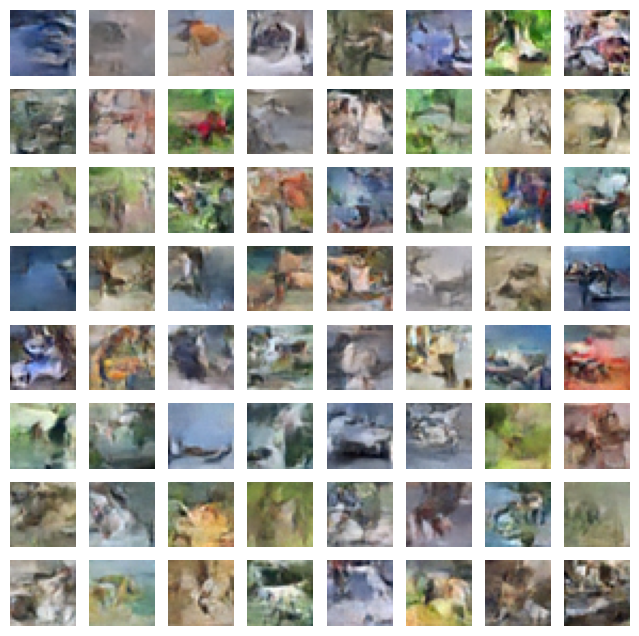

In [19]:
with torch.no_grad():
    model.eval()
    x=torch.randn(64,3,31,31).to(Device)
    timesteps=1000
    for i in range(0,timesteps-1):
        t=timesteps-i
        x=DDIM_sampler(model,x,t,n=1)
        #x=torch.clamp(DDIM_sampler(model,x,t,n=1),-1,1)
        if i%100==0:
            #img_visualizer(x[0].detach().to('cpu'))
            print(i)
    #img_visualizer(x[0].detach().to('cpu'))
    x=x[:64]
    x=x*0.5+0.5
    x=x.permute(0,2,3,1) 
    x=x.view(8,8,31,31,3)
    x = x.to('cpu')
    image_np = x.numpy()
    
    # Create a figure and a set of subplots arranged in an 8x8 grid
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    
    # Iterate through the subplots and display each image
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(image_np[i, j], cmap='gray')
            axes[i, j].axis('off')  # Turn off axis labels
    plt.savefig('samples.jpeg')
    plt.show()

In [ ]:
def DDPM_sampler(model,image,t,T=1000,n=1,mode="Cosine"):
    shape=image.shape
    if t>1:
        noise=torch.randn(shape).to(Device)
    else:
        noise=0
    pred_noise=model(image,t)
    ut,sigmat=get_at(t,T,mode)
    ut1,sigmat1=get_at(t-1,T,mode)
    c1=ut1/ut
    c2=1-math.pow(ut/ut1,2)
    c2=c2/sigmat

    return ((image-c2*pred_noise)*c1)+sigmat*noise

In [ ]:
x=torch.randn(64,1,31,31).to(Device)
timesteps=1000
for i in range(0,timesteps-1):
    t=timesteps-i
    x=DDIM_sampler(model,x,t,1)
    if i%100==0:
        img_visualizer(x[0].to('cpu'))
        print(i)
data_visualizer(x[:64].to('cpu'))